In [2]:
import MDAnalysis as mda
import warnings
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from MDAnalysis.analysis import distances
import re
from collections import Counter
import seaborn as sns
warnings.filterwarnings('ignore')
import os


/home/yiechang/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


The code below records binding events between different PIP species (POP1, POP2, POP3) and our proposed binding site (comprised of residues in VSD-IV and the DIII-IV linker of Nav1.4) and determines the length of the binding interaction.

In [6]:
##a function to remove repeating zeroes, used to calculate continuous binding time 
def remove_adjacent(nums):
  i = 0
  while i < len(nums):    
    if nums[i] == nums[i-1]:
        if nums[i] == 0:
            nums.pop(i)
            i -= 1  
    i += 1
  return nums
  
#make a dataframe and select binding residues 
all=pd.DataFrame()
vresnames=['R1460','R1463', 'K1466', 'R1469']
iresnames=['K1329', 'K1330', 'K1333', 'K1352']
reps=['rep1', 'rep2', 'rep3', 'rep4', 'rep5', 'rep6', 'rep7', 'rep8', 'rep9', 'rep10']

vsd=pd.DataFrame()
ifm=pd.DataFrame()
for r in reps:
    #loop through replicate trajectories 
    u=mda.Universe('traj/labelled_s.gro', 'traj/'+r+'_s.xtc')
    #select the side chain bead of PIP binding residues in VSD-IV 
    vpbs=u.select_atoms('resid 991 994 997 1000 and name SC2')
    #select the side chain bead of PIP binding residues on the DIII-IV linker
    ipbs=u.select_atoms('resid 860 861 864 883 and name SC2')
    pip=u.select_atoms('resname POP1 POP2 POP3').residues 
    all=pd.DataFrame()
    #quick filter to find binding PIPs
    for residue in pip:
        #for each PIP molecule in the system 
        count=[]
        for ts in u.trajectory[::200]:
            #check frames in strided trajectory 
            df=pd.DataFrame(distances.distance_array(residue.atoms.positions,vpbs.positions), columns=vresnames)
            #compute distance between PIP molecule and VSD-IV binding residues 
            vc=(df.min()<7).value_counts().get(True)
            #determine whether the distance from PIP to at least one VSD binding residue is < 7 A  
            if vc is not None and vc>1:
                count.append(1)
            else: 
                count.append(0)
        all[residue.resid]=count
        #put this information in a dataframe 
        all=all.loc[:, (all.sum() > 1)]

    bindingpips=" ".join(list((all.rolling(2).mean()>0.5).any().index.astype(str)))
    #find PIP molecules which remain within 7 A of a VSD binding residue for two or more continuous strided frames (gap of 2 us between frames)
    pip=u.select_atoms('resid '+bindingpips).residues
    #for these PIP molecules, analyse interactions more closely 
    for residue in pip:
        count=[]
        for ts in u.trajectory[::10]:
            #check every 100 ns 
            df=pd.DataFrame(distances.distance_array(residue.atoms.positions,vpbs.positions), columns=vresnames)
            vc=(df.min()<7).value_counts().get(True)
            #for every frame, record how many VSD binding residues it is interacting with 
            if vc is not None and vc>0:
                count.append(vc)
            else: 
                count.append(0)
        vsd[r+'-'+residue.resname+'-'+str(residue.resid)]=count
        count=[]
        for ts in u.trajectory[::10]:
            df=pd.DataFrame(distances.distance_array(residue.atoms.positions,ipbs.positions), columns=iresnames)
            vc=(df.min()<7).value_counts().get(True)
            #record how many DIII-IV linker binding residues it is interacting with 
            if vc is not None and vc>0:
                count.append(vc)
            else: 
                count.append(0)
        ifm[r+'-'+residue.resname+'-'+str(residue.resid)]=count


7 15 9


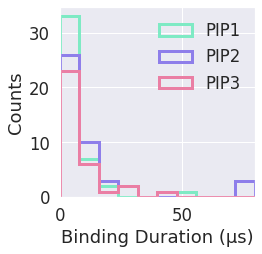

In [7]:
##now we work out the length of continuous binding interactions 

#make some lists for different PIP types 
pips=[]
p1=[]
p2=[]
p3=[]

#loop through binding PIPs 
for i in vsd.columns:
    clean=remove_adjacent(vsd[i].tolist())
    #convert the column to a list, remove adjacent zeros. for example, '1110000123' becomes '1110123'  
    string="".join(map(str,clean))
    #convert it into a string so that we can do some string-y things to it 
    sstring=re.split('0', string)
    #break the string up by 0s - that separates out individual binding events for the same PIP (for example, when the same PIP binds, dissociates, then rebinds at the site)
    a=[]
    for s in sstring:
        if len(s)>19:
            #only count binding interactions 2 us or greater 
            pips.append(i)
            #only count as binding if PIP molecule interacts with 2 or more VSD binding residues at some point during the interaction 
            if "2" in s:
                a.append(s)
            elif "3" in s:
                a.append(s)
            elif "4" in s:
                a.append(s)
    for ss in a:
        ss=ss.replace('1', '0')
        ss=ss.replace('2', '1')
        ss=ss.replace('3', '1')
        ss=ss.replace('4', '1')
        res=i[5:-5]
        #separate by PIP type 
        if res=='POP1':
            p1.append((ss.rfind('1')-ss.find('1'))/10)
            #find the length of time between the first and last frames where two or more interactions are formed with VSD binding residues 
        elif res=='POP2':
            p2.append((ss.rfind('1')-ss.find('1'))/10)
        elif res=='POP3': 
            p3.append((ss.rfind('1')-ss.find('1'))/10)

#make the binding time distribution plot 
plt.figure(figsize=(3.5,3.5))
plt.hist([p3, p2, p1], alpha=1, bins=10, histtype='step', color=['#ea7ea4', '#8e7eea', '#7eeac4'], lw=3, label=['PIP3', 'PIP2', 'PIP1'])
plt.xlim(0,80)
plt.legend(ncol=1, frameon=False)
plt.xlabel('Binding Duration (μs)')
plt.ylabel('Counts')
plt.savefig('Fig3B.svg', dpi=600, bbox_inches="tight")

#now get only the long (> 10 us) interactions 
lpips=[]
vlpips=[]
p1=[]
p2=[]
p3=[]
for i in vsd.columns:
    clean=remove_adjacent(vsd[i].tolist())
    string="".join(map(str,clean))
    sstring=re.split('0', string)
    a=[]
    for s in sstring:
        if len(s)>99:
            lpips.append(i)
            if "2" in s:
                a.append(s)
            elif "3" in s:
                a.append(s)
            elif "4" in s:
                a.append(s)
        if len(s)>299: 
            vlpips.append(i)
    for ss in a:
        ss=ss.replace('1', '0')
        ss=ss.replace('2', '1')
        ss=ss.replace('3', '1')
        ss=ss.replace('4', '1')
        res=i[5:-5]
        if res=='POP1':
            p1.append((ss.rfind('1')-ss.find('1'))/10)
        elif res=='POP2':
            p2.append((ss.rfind('1')-ss.find('1'))/10)
        elif res=='POP3':
            p3.append((ss.rfind('1')-ss.find('1'))/10)
print(len(p1),len(p2),len(p3))

For interactions between PIP and the binding site lasting over 10 us, make heatmaps of the binding interaction 

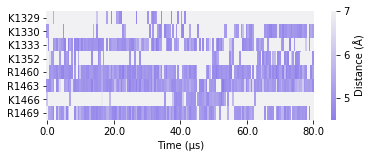

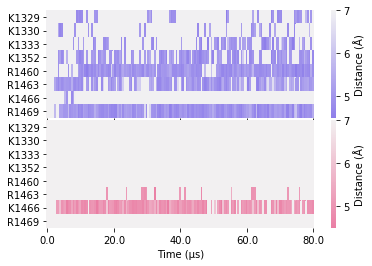

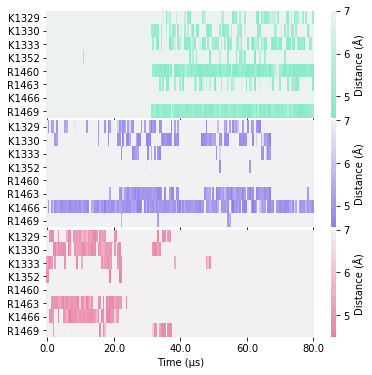

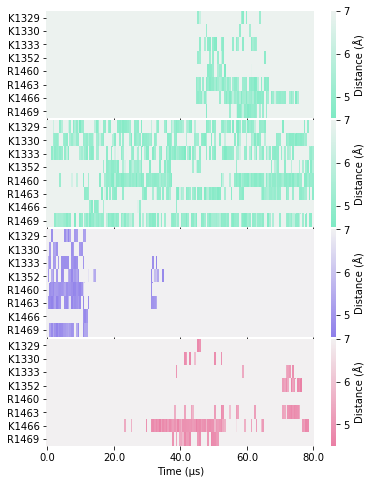

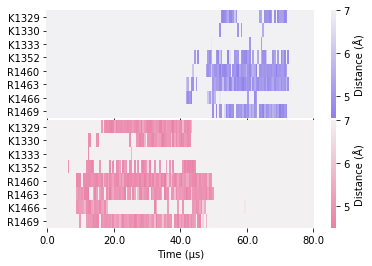

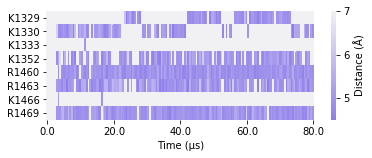

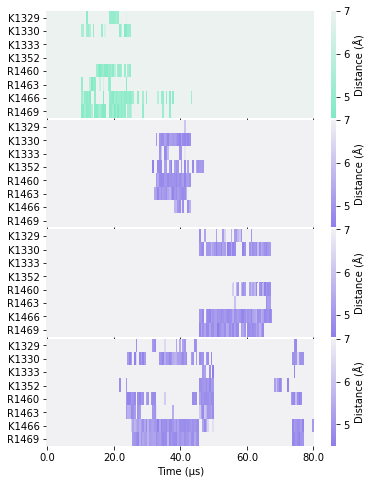

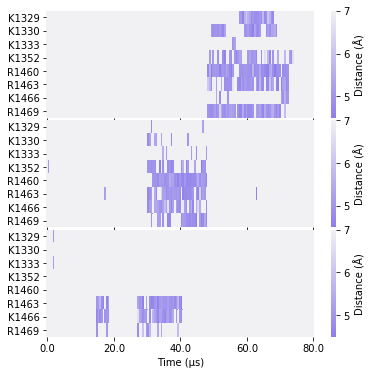

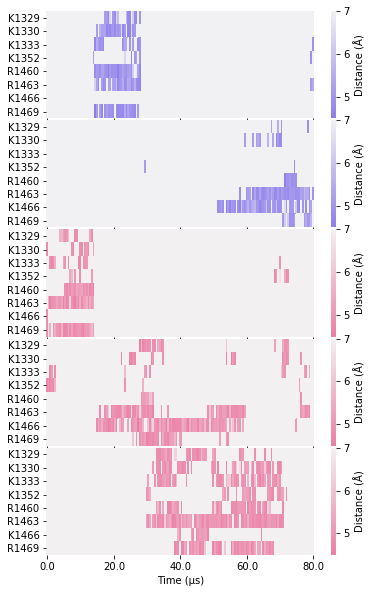

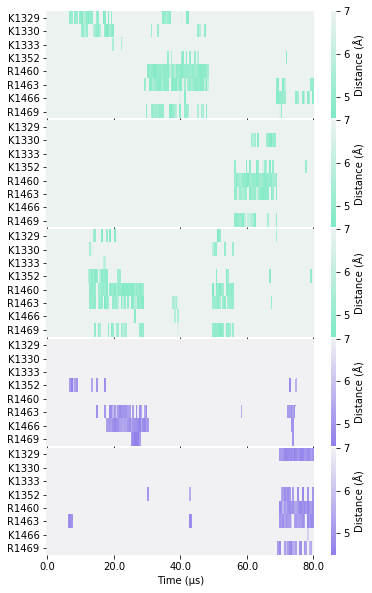

In [38]:
pb=['K1329', 'K1330', 'K1333', 'K1352', 'R1460','R1463', 'K1466', 'R1469']
amino = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K','ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 'GLY': 'G', 'HIS': 'H', 'HSD': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}
sel= 'resid 860 861 864 883 991 994 997 1000 and name SC2'
pbs=list(pd.Series(u.select_atoms(sel).resnames).map(amino) + u.select_atoms(sel).resids.astype(str))

color= {'POP1': '#7eeac4',
        'POP2' : '#8e7eea',
        'POP3': '#ea7ea4' }

#define a function to plot heatmaps 
def heatmap(residue, rep, num):
    dhm=pd.DataFrame(index=pb)
    for ts in u.trajectory[::50]:
        df=pd.DataFrame(distances.distance_array(residue.atoms.positions, pbs.center_of_mass(compound='residues')), columns=pb)
        #get the distance between each bead of the PIP molecule and the COM of each binding residue 
        a=[]
        for i in pb:
            a.append(df.min()[i].min())
            #find the minimum distance between PIP and binding residue 
        dhm[ts.frame]=a
    dhm.columns=dhm.columns/100
    cmap=sns.light_palette(color[residue.resname], reverse=True, as_cmap=True)
    #make a color palette based on PIP type 
    if j not in ['rep1-', 'rep6-']:
        #have to do this for replicates with only one long binding PIP otherwise script breaks 
        sns.heatmap(dhm, vmax=7, vmin=4.5, cmap=cmap, xticklabels=40, ax=axes[num], cbar_kws={'label':"Distance (Å)", 'shrink':1, 'ticks':[5,6,7]})
    else:
        fig, ax = plt.subplots(figsize=(6,2))
        #make subplots for replicates with multiple long binding events 
        sns.heatmap(dhm, vmax=7, vmin=4.5, cmap=cmap, xticklabels=40, ax=ax, cbar_kws={'label':"Distance (Å)", 'shrink':1, 'ticks':[5,6,7]})
        plt.xlabel('Time (μs)')

#loop through replicate trajectories and make heatmaps for the PIP molecules which interact with the binding site for > 10 us 
for j in ['rep1-', 'rep2-', 'rep3-', 'rep4-', 'rep5-', 'rep6-', 'rep7-', 'rep8-', 'rep9-', 'rep10']:
    rlist=[ x for x in np.unique(lpips)if x[:5]==j ]
    if len(rlist)>1:
        fig, axes = plt.subplots(nrows=len(rlist), sharex='all', figsize=(6,len(rlist)*2))
    num=0
    for i in rlist:
        l=i.split('-')
        rep=l[0]
        restype=l[1]
        resid=l[2]
        u=mda.Universe('traj/labelled_s.gro', 'traj/'+rep+'_s.xtc')
        pbs=u.select_atoms('name SC2 and same resid as '+sel)
        interacting_lip=u.select_atoms('(resname '+restype+' and resid '+ resid+')').residues
        for residue in interacting_lip:
            heatmap(residue, rep, num)
            num += 1
    plt.subplots_adjust(hspace=0.02, wspace=1)
    plt.xlabel('Time (μs)')
    plt.savefig(j+'hm.svg', dpi=300, bbox_inches="tight")

Make the heatmaps for the main figure, show only the 6 top binding events. 

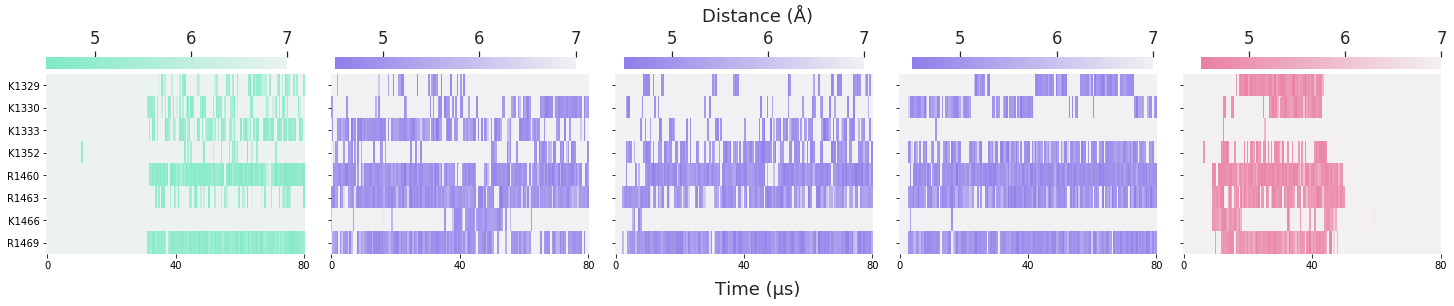

In [4]:
pb=['K1329', 'K1330', 'K1333', 'K1352', 'R1460','R1463', 'K1466', 'R1469']
sel= 'resid 860 861 864 883 991 994 997 1000'
reps=['rep3', 'rep1', 'rep2', 'rep6', 'rep5']
label=['PIP1', 'PIP2', 'PIP2', 'PIP2', 'PIP3']

os.system('cd PIPsel; bash pip.sh')
color= {'POP1': '#7eeac4',
        'POP2' : '#8e7eea',
        'POP3': '#ea7ea4' }

def heatmap(residue, rep, num):
    dhm=pd.DataFrame(index=pb)
    for ts in u.trajectory[::50]:
        df=pd.DataFrame(distances.distance_array(residue.atoms.positions, pbs.center_of_mass(compound='residues')), columns=pb)
        a=[]
        for i in pb:
            a.append(df.min()[i].min())
        dhm[ts.frame]=a
    dhm.columns=(dhm.columns/100).astype(int)
    cmap=sns.light_palette(color[residue.resname], reverse=True, as_cmap=True)
    sns.set(font_scale = 1.5)
    sns.heatmap(dhm, vmax=7, vmin=4.5, cmap=cmap, xticklabels=80, ax=axes[num], cbar_kws={'use_gridspec':False, 'location':"top", 'shrink':1})#;, 'ticks':['5', '6', '7']})
    ax=axes[num]

fig, axes = plt.subplots(ncols=len(reps), sharey='all', figsize=(len(reps)*5, 4))
num=0
for rep in reps:
    u=mda.Universe('traj/labelled_s.gro', 'traj/'+rep+'_s.xtc')
    pbs=u.select_atoms('name SC2 and '+sel)
    df=pd.read_csv('PIPsel/'+rep+'/PIP.txt', sep=' ', header=None)
    df.columns=['Resname', 'Resid', 'Occupancy']
    df=df.sort_values('Occupancy', ascending=False).reset_index()
    interacting_lip=u.select_atoms('(resname '+df['Resname'][0]+' and resid '+ str(df['Resid'][0])+')').residues
    for residue in interacting_lip:
        heatmap(residue, rep, num)
        num += 1
plt.subplots_adjust(top=0.75, wspace=0.1, hspace=None)
fig=plt.gcf()
fig.text(0.52,0, "Time (μs)", ha="center", va="center")
fig.text(0.52,0.95, "Distance (Å)", ha="center", va="center")
plt.savefig('Fig3X.svg', dpi=600, bbox_inches="tight")

In [47]:
#there's probably a better way to do this, but I don't know it 
all=vsd+ifm

#equivalent to the remove_adjacent but now does DIII-IV linker and all lists as well 
def remove(vsd, ifm, all):
  i = 1
  while i < len(vsd):    
    if vsd[i] == vsd[i-1]:
        if vsd[i] == 0:
            #if not bound to VSD residue, then don't count DIII-IV linker interactions 
            vsd.pop(i)
            ifm.pop(i)
            all.pop(i)
            i -= 1  
    i += 1
  return vsd, ifm, all 
 
def find(s, ch):
    return [i for i, ltr in enumerate(s) if ltr == ch]
    
vp1=[]
vp2=[]
vp3=[]
ip1=[]
ip2=[]
ip3=[]
ap1=[]
ap2=[]
ap3=[]

for i in vsd.columns:
    clean=remove(vsd[i].tolist(), ifm[i].tolist(), all[i].tolist())
    #clean the interaction lists 
       
    vstring="".join(map(str,clean[0]))
    istring="".join(map(str,clean[1]))
    astring="".join(map(str,clean[2]))
    #convert to string to do stringy things 

    svstring=re.split('0', vstring)
    indices=[0]
    indices=indices+find(vstring, '0')+[len(vstring)]
    sistring = [istring[i+1:j] for i,j in zip(indices, indices[1:]+[None])]
    sastring = [astring[i+1:j] for i,j in zip(indices, indices[1:]+[None])]
    #split based on 0s (not interacting)
      
    a=[]
    b=[]
    c=[]
    
    #count binding interactions if and only if PIP interacts with 2 or more VSD-IV residues during the interaction 
    for j in range(len(svstring)):
        s=svstring[j]
        if len(s)>5:
            if "2" in s:
                a.append(s)
                b.append(sistring[j])
                c.append(sastring[j])
            elif "3" in s:
                a.append(s)
                b.append(sistring[j])
                c.append(sastring[j])
            elif "4" in s:
                a.append(s)
                b.append(sistring[j])
                c.append(sastring[j])

    #record the number of interacting DIII-IV linker and VSD-IV residues when binding is occurring 
    for k in range(len(a)):
        ss=a[k]
        aa=ss.replace('1', '0')
        aa=aa.replace('2', '1')
        aa=aa.replace('3', '1')
        aa=aa.replace('4', '1')
        ifs=b[k]
        als=c[k]
        res=i[5:-5]
        if res=='POP1':
            vp1.append(ss[aa.find('1'):aa.rfind('1')])
            ip1.append(ifs[aa.find('1'):aa.rfind('1')])
            ap1.append(als[aa.find('1'):aa.rfind('1')])
        elif res=='POP2':
            vp2.append(ss[aa.find('1'):aa.rfind('1')])
            ip2.append(ifs[aa.find('1'):aa.rfind('1')])
            ap2.append(als[aa.find('1'):aa.rfind('1')])
        elif res=='POP3':
            vp3.append(ss[aa.find('1'):aa.rfind('1')])
            ip3.append(ifs[aa.find('1'):aa.rfind('1')])
            ap3.append(als[aa.find('1'):aa.rfind('1')])

vp1dist=list(map(int,list("".join(vp1))))
vp2dist=list(map(int,list("".join(vp2))))
vp3dist=list(map(int,list("".join(vp3))))

ip1dist=list(map(int,list("".join(ip1))))
ip2dist=list(map(int,list("".join(ip2))))
ip3dist=list(map(int,list("".join(ip3))))

ap1dist= [sum(x) for x in zip(vp1dist, ip1dist)]
ap2dist= [sum(x) for x in zip(vp2dist, ip2dist)]
ap3dist= [sum(x) for x in zip(vp3dist, ip3dist)]

vfreq=pd.DataFrame(columns=['PIP1', 'PIP2', 'PIP3'], index=[1,2,3,4])
vfreq['PIP1']=Counter(vp1dist).values()
vfreq['PIP2']=Counter(vp2dist).values()
vfreq['PIP3']=Counter(vp3dist).values()
vfreq=vfreq.div(vfreq.sum())
#vfreq.plot.bar(subplots=True, layout=(1,6), figsize=(7,1), width=0.7, legend=False, rot=0, sharey=True, ylabel='Probability', title=['', '', ''], color=['#7eeac4','#8e7eea', '#ea7ea4'])

ifreq=pd.DataFrame(columns=['PIP1', 'PIP2', 'PIP3'], index=[0,1,2,3,4])
ifreq['PIP1']=Counter(ip1dist).values()
ifreq['PIP2']=Counter(ip2dist).values()
ifreq['PIP3']=Counter(ip3dist).values()
ifreq=ifreq.div(ifreq.sum())
#ifreq.plot.bar(subplots=True, layout=(1,6), figsize=(7,1), width=0.7, legend=False, rot=0, sharey=True, ylabel='Probability', title=['', '', ''], color=['#7eeac4','#8e7eea', '#ea7ea4'])


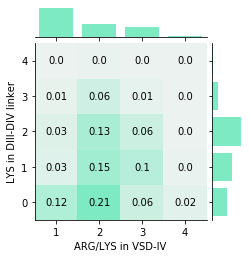

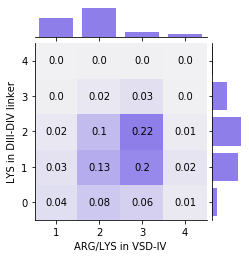

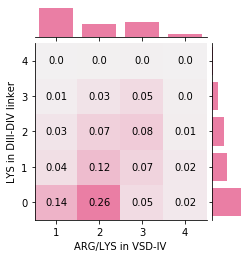

In [48]:
#plot all that 
g=sns.JointGrid(x=vp1dist, y=ip1dist, height=3.5)
cmap=sns.light_palette(color['POP1'], as_cmap=True)
plt.sca(g.ax_joint)
hist, xbins, ybins, im = plt.hist2d(vp1dist, ip1dist, bins=(np.arange(0.5, 5.5, 1), np.arange(-0.5, 5.5, 1)), cmap=cmap, normed=True)
for i in range(len(ybins)-1):
    for j in range(len(xbins)-1):
        plt.text(xbins[j]+0.5,ybins[i]+0.5, round(hist.T[i,j], 2), 
                color="black", ha="center", va="center")
plt.sca(g.ax_marg_x)
plt.bar(vfreq.index, vfreq['PIP1'], color='#7eeac4')
plt.sca(g.ax_marg_y)
plt.barh(ifreq.index, ifreq['PIP1'], color='#7eeac4')
g.ax_joint.set_xlabel('ARG/LYS in VSD-IV')
g.ax_joint.set_ylabel('LYS in DIII-DIV linker')
plt.savefig('Fig3_PIP1.svg', dpi=600, bbox_inches="tight")

g=sns.JointGrid(x=vp1dist, y=ip1dist, height=3.5)
cmap=sns.light_palette(color['POP2'], as_cmap=True)
plt.sca(g.ax_joint)
hist, xbins, ybins, im = plt.hist2d(vp2dist, ip2dist, bins=(np.arange(0.5, 5.5, 1), np.arange(-0.5, 5.5, 1)), cmap=cmap, normed=True)
for i in range(len(ybins)-1):
    for j in range(len(xbins)-1):
        plt.text(xbins[j]+0.5,ybins[i]+0.5, round(hist.T[i,j], 2), 
                color="black", ha="center", va="center")
plt.sca(g.ax_marg_x)
plt.bar(vfreq.index, vfreq['PIP2'], color=color['POP2'])
plt.sca(g.ax_marg_y)
plt.barh(ifreq.index, ifreq['PIP2'], color=color['POP2'])
g.ax_joint.set_xlabel('ARG/LYS in VSD-IV')
g.ax_joint.set_ylabel('LYS in DIII-DIV linker')
plt.savefig('Fig3_PIP2.svg', dpi=600, bbox_inches="tight")

g=sns.JointGrid(x=vp1dist, y=ip1dist, height=3.5)
cmap=sns.light_palette(color['POP3'], as_cmap=True)
plt.sca(g.ax_joint)
hist, xbins, ybins, im = plt.hist2d(vp3dist, ip3dist, bins=(np.arange(0.5, 5.5, 1), np.arange(-0.5, 5.5, 1)), cmap=cmap, normed=True)
for i in range(len(ybins)-1):
    for j in range(len(xbins)-1):
        plt.text(xbins[j]+0.5,ybins[i]+0.5, round(hist.T[i,j], 2), 
                color="black", ha="center", va="center")
plt.sca(g.ax_marg_x)
plt.bar(vfreq.index, vfreq['PIP3'], color=color['POP3'])
plt.sca(g.ax_marg_y)
plt.barh(ifreq.index, ifreq['PIP3'], color=color['POP3'])
g.ax_joint.set_xlabel('ARG/LYS in VSD-IV')
g.ax_joint.set_ylabel('LYS in DIII-DIV linker')
plt.savefig('Fig3_PIP3.svg', dpi=600, bbox_inches="tight")